In [1]:
import os
import glob
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter, zoom
import pydicom


In [2]:
idx_mic = 900
idx_cl = 168

# Load Clinical CT Reference

In [3]:
# load
path_cl = "D:\\sunny\\Codes\\IIB_project\\data\\clinical_CT_data\\C001"

# Retrieve all DICOM files in the folder.
file_list = sorted(glob.glob(os.path.join(path_cl, "*.dcm")))

# Read the DICOM files.
slices_cl = [pydicom.dcmread(file) for file in file_list]

# Sort the slices based on InstanceNumber (or SliceLocation if needed)
slices_cl.sort(key=lambda s: int(s.InstanceNumber))

# Extract the pixel data and stack into a 3D volume.
data_cl_raw = np.stack([s.pixel_array for s in slices_cl], axis=0)
print("Volume shape:", data_cl_raw.shape)

Volume shape: (273, 512, 512)


# Load Micro CT Files

In [4]:
# Path to the folder containing JPEG images.
path_mic = "D:\\sunny\\Codes\\IIB_project\\data\\clinical_CT_data\\micro_ct"

# Use glob to get a sorted list of JPEG file paths.
file_list = sorted(glob.glob(os.path.join(path_mic, "*.jpg")))  # Adjust the extension if needed

# Load each image, convert to grayscale if needed, and store as a NumPy array.
slices_mic = []
for file in file_list:
    # Open the image and convert to grayscale ('L' mode) if necessary.
    # img = Image.open(file).convert('L')
    img = Image.open(file)
    slices_mic.append(np.array(img))

# Stack the 2D slices into a 3D volume.
data_mic = np.stack(slices_mic, axis=0)
print("Volume shape:", data_mic.shape)

Volume shape: (1201, 1704, 1681)


# Crop Clinical CT to have similar FoV

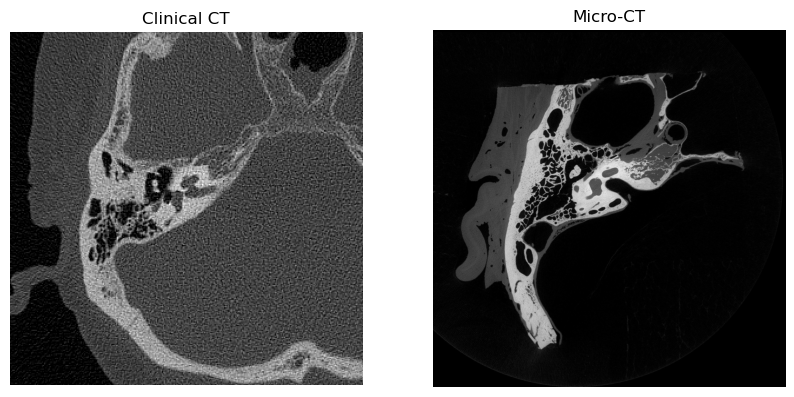

Clinical CT slice shape: (300, 300)
Micro-CT slice shape: (1704, 1681)


In [6]:
# Crop all slices to [128:384, 0:256] to sync FOV with the micro-CT data.
data_cl = data_cl_raw[:, 100:400, 0:300]

# visualize one slice vs a slice from micro-CT
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(data_cl[idx_cl], cmap='gray')
plt.axis('off')
plt.title("Clinical CT")
plt.subplot(1, 2, 2)
plt.imshow(data_mic[idx_mic], cmap='gray')
plt.axis('off')
plt.title("Micro-CT")
plt.show()

print("Clinical CT slice shape:", data_cl[idx_cl].shape)
print("Micro-CT slice shape:", data_mic[idx_mic].shape)

# 1. 3D Gaussian Blur

In [7]:
sigma = (2.5, 2.5, 5)  # Adjust these values as needed.
data_blur = gaussian_filter(data_mic, sigma=sigma)

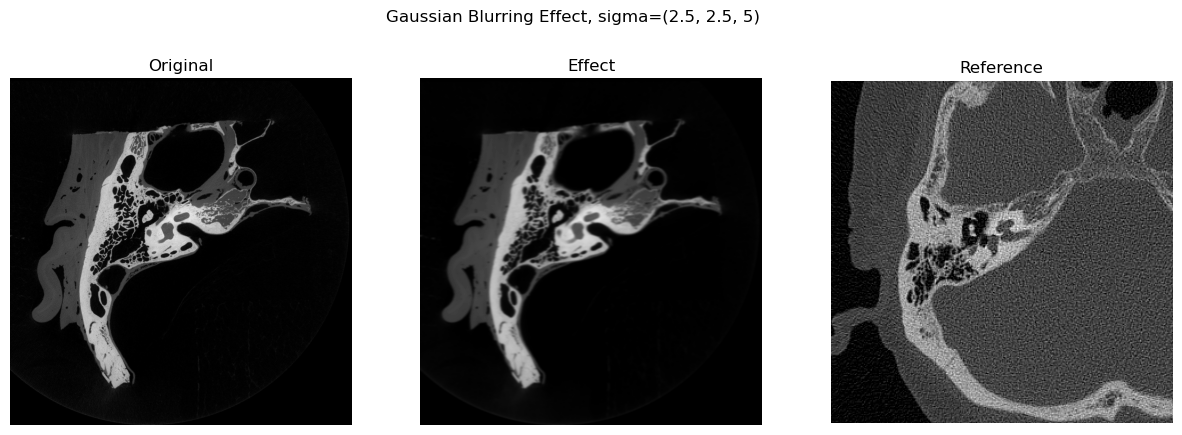

In [8]:
# visualized one slice before and after blurring, as well as clinical CT
def visualize_effect(origin, new, reference, idx_ls, description=None):
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    for ax in axes:
        ax.axis('off')
    axes[0].imshow(origin[idx_ls[0]], cmap='gray', vmin=0, vmax=255)
    axes[0].set_title("Original")
    axes[1].imshow(new[idx_ls[1]], cmap='gray', vmin=0, vmax=255)
    axes[1].set_title("Effect")
    axes[2].imshow(reference[idx_ls[2]], cmap='gray', vmin=0, vmax=4095)
    axes[2].set_title("Reference")
    if description is not None:
        fig.suptitle(description)
    plt.show()

visualize_effect(data_mic, data_blur, data_cl, [idx_mic, idx_mic, idx_cl], "Gaussian Blurring Effect, sigma=(2.5, 2.5, 5)")

# 2. Downsample

### a) Still preserve the Nyquist sampling theorem with cutoff frequency at 1% max magnitude

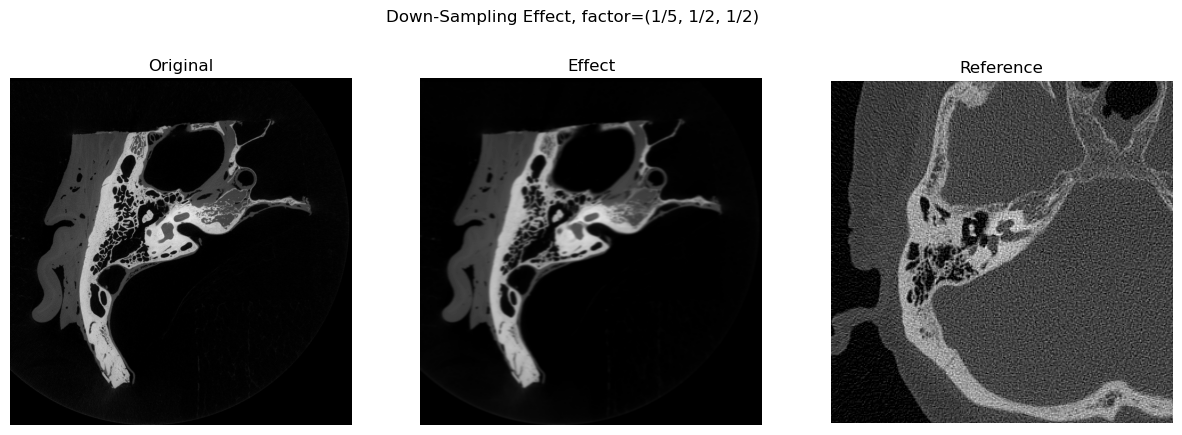

In [189]:
# define factors for down-sampling in each dimension
# still fulfill the Nyquist sampling theorem with cutoff frequency at 1% max magnitude
f_x = 2 # sigma = 2.5
f_y = 2 # sigma = 2.5
f_z = 5 # sigma = 5

# down-sample the blurred micro-CT data
data_ds = zoom(data_blur, zoom=(1/f_z, 1/f_x, 1/f_y), order=1)
idx_ds = idx_mic // f_z

# visualize one slice before and after down-sampling, as well as clinical CT
visualize_effect(data_mic, data_ds, data_cl, [idx_mic, idx_ds, idx_cl], "Down-Sampling Effect, factor=(1/5, 1/2, 1/2)")

### b) Try to match pixel dimensions of the clinical CT

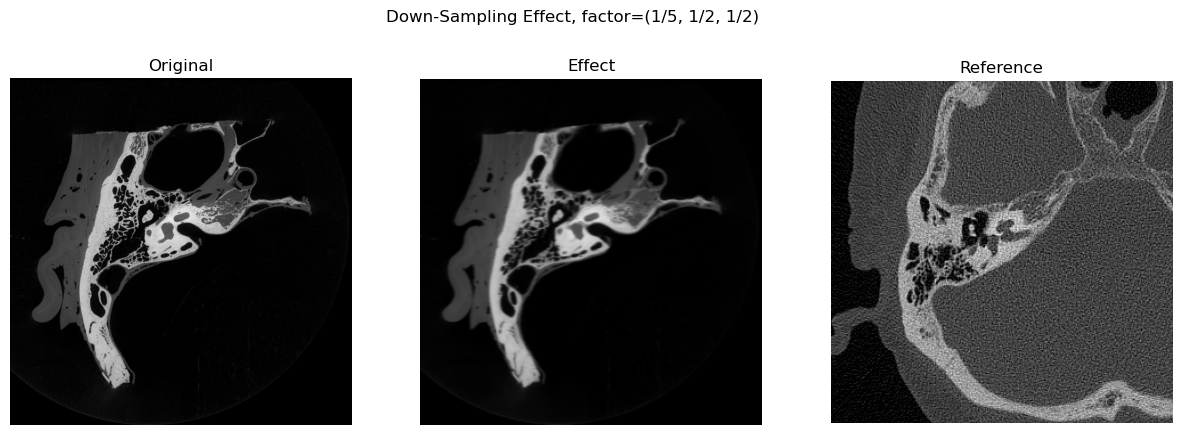

In [9]:
# define factors for down-sampling in each dimension
# discard the Nyquist sampling theorem with cutoff frequency at 1% max magnitude
# only try to match the pixel dimensions of the clinical CT
f_x = 5.5 # sigma = 2.5
f_y = 5.5 # sigma = 2.5
f_z = 5 # sigma = 5

# down-sample the blurred micro-CT data
data_ds = zoom(data_blur, zoom=(1/f_z, 1/f_x, 1/f_y), order=1)
idx_ds = idx_mic // f_z

# visualize one slice before and after down-sampling, as well as clinical CT
visualize_effect(data_mic, data_ds, data_cl, [idx_mic, idx_ds, idx_cl], "Down-Sampling Effect, factor=(1/5, 1/2, 1/2)")

In [10]:
print("Original shape:", data_mic.shape)
print("Down-sampled shape:", data_ds.shape)
print("Reference shape:", data_cl.shape)

Original shape: (1201, 1704, 1681)
Down-sampled shape: (240, 310, 306)
Reference shape: (273, 300, 300)


# 3. Added Image Noise

It is noticed that: <br>
- the clinical data (.dcm) is quantized into 13 bits (0-4095) <br>
- the micro-CT data (.jpeg) is quantized into 8 bits (0-255) 

Clinical CT intensity range: 0 4095
Down-sampled Micro-CT intensity range: 0 230


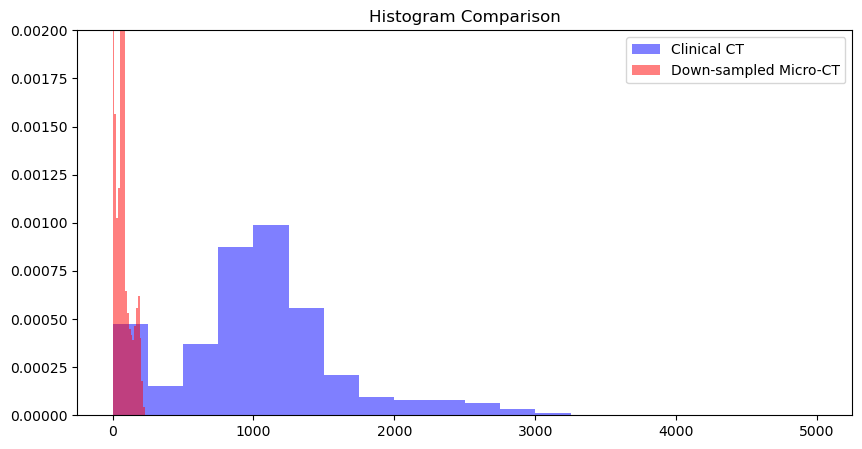

In [11]:
# print intensity range
print("Clinical CT intensity range:", data_cl.min(), data_cl.max())
print("Down-sampled Micro-CT intensity range:", data_ds.min(), data_ds.max())
# plot the normalized histogram of the clinical CT and the down-sampled micro-CT
plt.figure(figsize=(10, 5))
plt.hist(data_cl.ravel(), bins=20, range=(0, 5000), alpha=0.5, color='blue', label='Clinical CT', density=True)
plt.hist(data_ds.ravel(), bins=20, range=(0, 255), alpha=0.5, color='red', label='Down-sampled Micro-CT', density=True)
plt.ylim([0, 0.002])
plt.legend(loc='upper right')
plt.title("Histogram Comparison")
plt.show()


### a) Gaussian

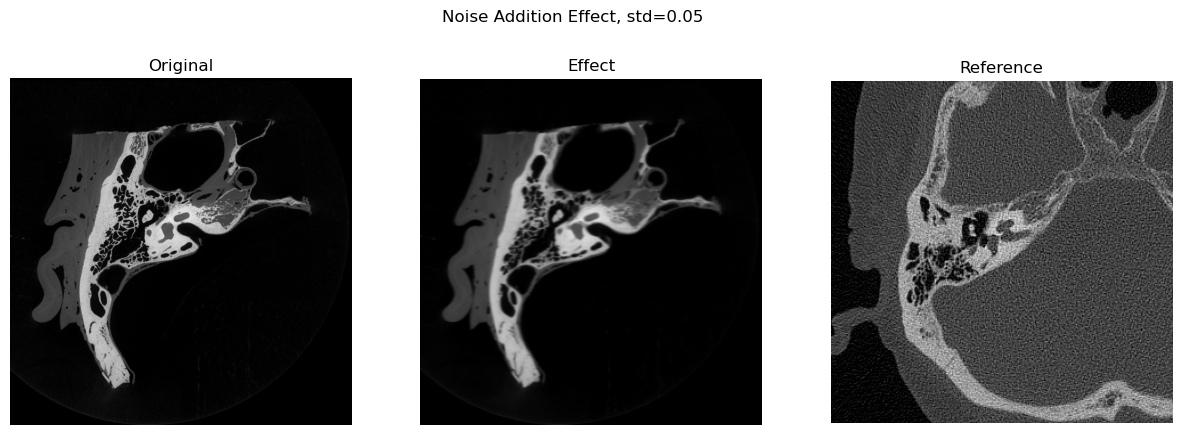

In [12]:
def gaussian_noise(image, std, mean=0):
    noise = np.random.normal(mean, std, image.shape)
    noise = np.clip(noise, -3*std, 3*std)  # clip to avoid intensity wrapping
    image_noise = np.clip(image + noise, 0, 255).astype(np.uint8)
    return image_noise

data_gauss = gaussian_noise(data_ds, std=0.05)

# visualize one slice before and after adding noise, as well as clinical CT
visualize_effect(data_mic, data_gauss, data_cl, [idx_mic, idx_ds, idx_cl], "Noise Addition Effect, std=0.05")

### b) Poisson Noise (due to photon scattering)

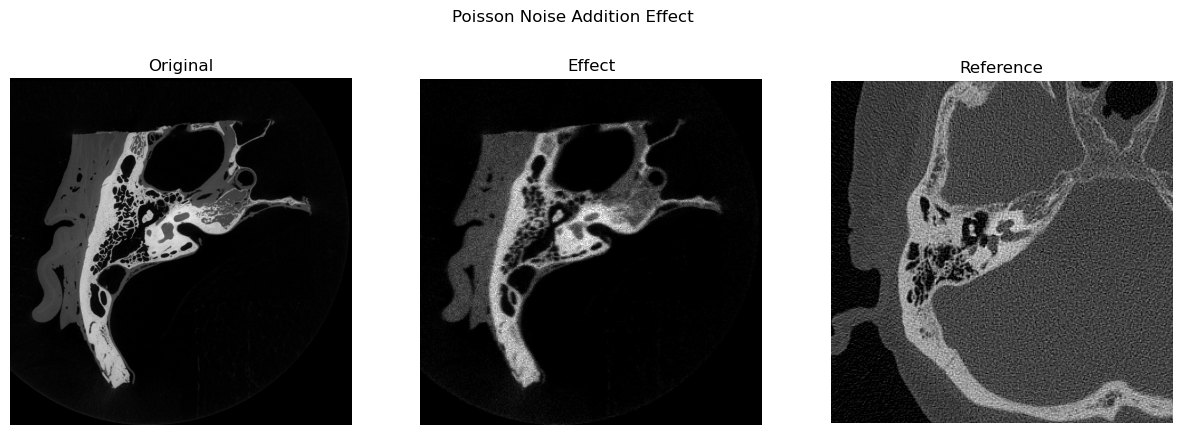

In [13]:
def poisson_noise(image, scale):
    image_scaled = image * scale
    noisy = np.random.poisson(image_scaled)
    # Scale back to the original intensity range.
    # Clip to ensure the intensity values are within the valid range.
    image_noisy = np.clip(noisy / scale, 0, 255).astype(np.uint8)
    return noisy / scale

# Add Poisson noise to the ds data with gaussian noise
data_poi = poisson_noise(data_ds, scale=0.5)
visualize_effect(data_mic, data_poi, data_cl, [idx_mic, idx_ds, idx_cl], "Poisson Noise Addition Effect")


### c) Film grain 

In [14]:
def filmgrain_noise(image, grain_strength=0.05, grain_size=3):
    """
    Add film grain noise to an image (2D or 3D).
    
    Parameters:
        image (np.array): Input image or volume.
        grain_strength (float): Scaling factor for the grain intensity.
        grain_size (int): Kernel size for blurring the noise to simulate grain size. 
                          Use an odd integer (e.g., 3, 5, 7) to control the coarseness.
                          
    Returns:
        np.array: Image with film grain noise added.
    """
    # Generate random noise with the same shape as the image
    noise = np.random.randn(*image.shape)
    
    # If using a 2D image, apply a Gaussian blur to simulate grain structure.
    # For 3D volumes, you could apply a 3D Gaussian filter similarly.
    if image.ndim == 2:
        noise = gaussian_filter(noise, (grain_size, grain_size), 0)
    elif image.ndim == 3:
        sigma = grain_size / 3.0
        noise = gaussian_filter(noise, sigma=sigma)
    
    # # Scale the noise and add it to non-zero pixel of the image
    # non_zero_idx = image > 0
    # image_noise = image.copy()
    # image_noise = image_noise.astype(np.float32)
    # image_noise[non_zero_idx] += grain_strength * noise[non_zero_idx]

    image_noise = image + grain_strength * noise
    image_noise = np.clip(image_noise, 0, 255).astype(np.uint8)
    return image_noise

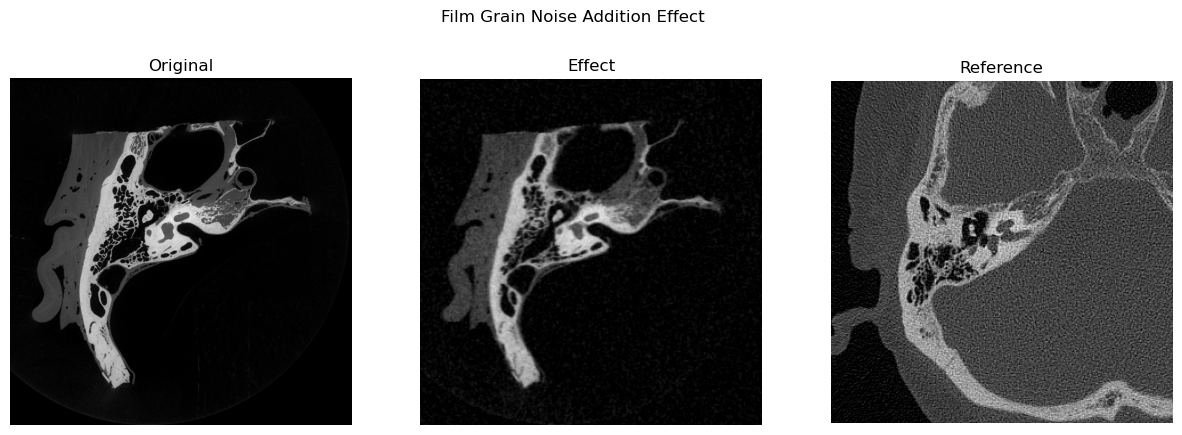

In [15]:
data_fg = filmgrain_noise(data_ds, grain_strength=25, grain_size=2)
visualize_effect(data_mic, data_fg, data_cl, [idx_mic, idx_ds, idx_cl], "Film Grain Noise Addition Effect")

### d) Reduce Contrast

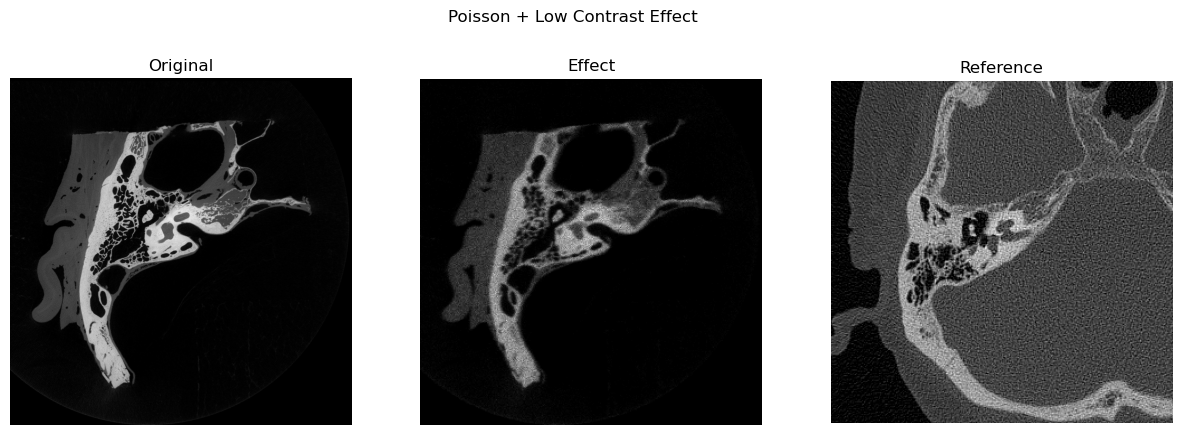

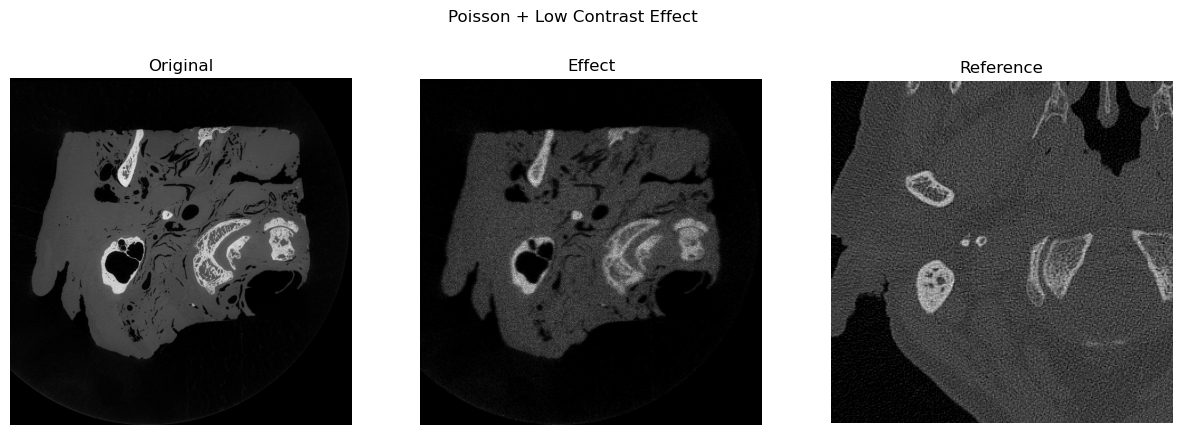

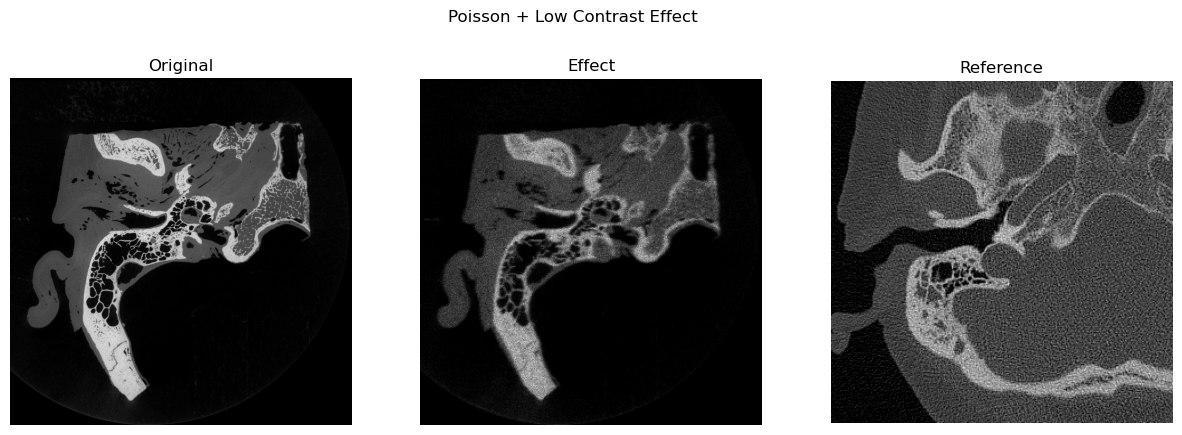

In [16]:
def reduce_contrast(image, factor):
    """
    Reduce the contrast of an image by scaling the intensity range.
    
    Parameters:
        image (np.array): Input image or volume.
        factor (float): Scaling factor for the intensity range.
        
    Returns:
        np.array: Image with reduced contrast.
    """
    image_low_contrast = image.astype(np.float32) * factor
    image_low_contrast = np.clip(image_low_contrast, 0, 255).astype(np.uint8)
    return image_low_contrast

data_rc = reduce_contrast(data_poi, factor=0.8)
visualize_effect(data_mic, data_rc, data_cl, [idx_mic, idx_ds, idx_cl], "Poisson + Low Contrast Effect")
visualize_effect(data_mic, data_rc, data_cl, [idx_mic-100*5, idx_ds-100, idx_cl-100], "Poisson + Low Contrast Effect")
visualize_effect(data_mic, data_rc, data_cl, [idx_mic-30*5, idx_ds-30, idx_cl-30], "Poisson + Low Contrast Effect")

# Save Processed Data

In [19]:
def save_as_jpeg(data, output_folder):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    
    num_slices = data.shape[0]
    for i in range(num_slices):
        slice_img = data[i]
        # Normalize the slice to 0-255 and convert to uint8
        # norm_slice = 255 * (slice_img - slice_img.min()) / (slice_img.max() - slice_img.min())
        # norm_slice = norm_slice.astype(np.uint8)
        img = Image.fromarray(slice_img.astype(np.uint8))
        filename = os.path.join(output_folder, f"slice_{i:03d}.jpeg")
        img.save(filename)
    print(f"Saved all slices of processed data", end='\r')

In [ ]:
output_folder = "D:\\sunny\\Codes\\IIB_project\\data\\clinical_CT_data\\pseudo_ct"
save_as_jpeg(data_rc, output_folder)    

# Process combined mesh

In [2]:
# Combine a few ply files into one
import open3d as o3d
import numpy as np
import os

paths = ["D:\\sunny\\Codes\\IIB_project\\data\\1_summer\\microCT_facialNerve.ply",
         "D:\\sunny\\Codes\\IIB_project\\data\\1_summer\\microCT_incus.ply",
         "D:\\sunny\\Codes\\IIB_project\\data\\1_summer\\microCT_oticCapsule.ply",
         "D:\\sunny\\Codes\\IIB_project\\data\\1_summer\\microCT_pinna.ply",
         "D:\\sunny\\Codes\\IIB_project\\data\\1_summer\\microCT_sigmoidSinus.ply"]

meshes = [o3d.io.read_triangle_mesh(path) for path in paths]

combined_mesh = o3d.geometry.TriangleMesh()
for mesh in meshes:
    combined_mesh += mesh

output_path = "D:\\sunny\\Codes\\IIB_project\\data\\6_clinical_CT_data\\pseudo_wxdcm\\pseudo_ct_mesh.ply"
o3d.io.write_triangle_mesh(output_path, combined_mesh)

# Load the combined mesh and visualize
mesh_visual = o3d.io.read_triangle_mesh(output_path)
o3d.visualization.draw_geometries([mesh_visual], mesh_show_wireframe=True)



[Open3D WARNING] GLFW Error: WGL: Failed to make context current: 句柄无效。 


# Visualise alignment b/w GT microCT vs pseudoCT mesh

In [2]:
import open3d as o3d
mesh_micro = o3d.io.read_triangle_mesh("D:\\sunny\Codes\\IIB_project\\data\\2_michaelmas\\ear.ply")
mesh_pseudo = o3d.io.read_triangle_mesh("D:\\sunny\\Codes\\IIB_project\\data\\6_clinical_CT_data\\pseudo_wxdcm\\pseudo_ct_mesh.ply") 

o3d.visualization.draw_geometries([mesh_micro, mesh_pseudo], mesh_show_wireframe=True)

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
[Open3D WARNING] GLFW Error: WGL: Failed to make context current: 句柄无效。 
[Open3D WARNING] GLFW Error: WGL: Failed to make context current: 句柄无效。 
[Open3D WARNING] GLFW Error: WGL: Failed to make context current: 句柄无效。 
[Open3D WARNING] GLFW Error: WGL: Failed to make context current: 不支持请求的转换操作。 
[Open3D WARNING] GLFW Error: WGL: Failed to make context current: 不支持请求的转换操作。 
[Open3D WARNING] GLFW Error: WGL: Failed to make context current: 句柄无效。 
[Open3D WARNING] GLFW Error: WGL: Failed to make context current: 不支持请求的转换操作。 
[Open3D WARNING] GLFW Error: WGL: Failed to make context current: 不支持请求的转换操作。 
[Open3D WARNING] GLFW Error: WGL: Failed to make context current: 不支持请求的转换操作。 
[Open3D WARNING] GLFW Error: WGL: Failed to make context current: 不支持请求的转换操作。 
[Open3D WARNING] GLFW Error: WGL: Failed to make context current:

# Convert .tiff to .dcm files

In [1]:
import os
import glob
import numpy as np
from PIL import Image
import pydicom
from pydicom.dataset import FileDataset
import datetime
import pydicom.uid

def tiff_to_dcm(tiff_path, dcm_path):
    """
    Convert a single TIFF image into a DICOM file.

    Parameters:
        tiff_path (str): Path to the input TIFF file.
        dcm_path (str): Path to save the output DICOM file.
    """
    # Open the TIFF image using Pillow
    image = Image.open(tiff_path)
    # Convert the image to a NumPy array
    arr = np.array(image)

    # Create file meta information
    file_meta = pydicom.Dataset()
    file_meta.MediaStorageSOPClassUID = pydicom.uid.SecondaryCaptureImageStorage
    file_meta.MediaStorageSOPInstanceUID = pydicom.uid.generate_uid()
    file_meta.ImplementationClassUID = pydicom.uid.generate_uid()

    # Create the FileDataset instance
    ds = FileDataset(dcm_path, {}, file_meta=file_meta, preamble=b"\0" * 128)

    # Populate minimal DICOM metadata (customize as needed)
    ds.PatientName = "Batch^Converted"
    ds.PatientID = "0001"
    ds.Modality = "OT"  # 'Other'
    ds.StudyInstanceUID = pydicom.uid.generate_uid()
    ds.SeriesInstanceUID = pydicom.uid.generate_uid()
    ds.SOPInstanceUID = file_meta.MediaStorageSOPInstanceUID
    ds.StudyDate = datetime.datetime.now().strftime('%Y%m%d')
    ds.StudyTime = datetime.datetime.now().strftime('%H%M%S')

    # Set image dimensions and photometric interpretation
    if arr.ndim == 2:
        rows, cols = arr.shape
        ds.Rows = rows
        ds.Columns = cols
        ds.SamplesPerPixel = 1
        ds.PhotometricInterpretation = "MONOCHROME2"
    elif arr.ndim == 3:
        # Assuming the image is RGB
        rows, cols, _ = arr.shape
        ds.Rows = rows
        ds.Columns = cols
        ds.SamplesPerPixel = arr.shape[2]
        ds.PhotometricInterpretation = "RGB"
    else:
        raise ValueError("Unsupported image dimensions.")

    print(f"Original image bit depth: {arr.dtype}")
    # Set bit depth information
    if arr.dtype == np.uint8:
        ds.BitsAllocated = 8
    elif arr.dtype == np.uint16:
        ds.BitsAllocated = 16
    else:
        # Convert other types to 16-bit unsigned integers
        arr = arr.astype(np.uint16)
        ds.BitsAllocated = 16

    ds.BitsStored = ds.BitsAllocated
    ds.HighBit = ds.BitsStored - 1
    ds.PixelRepresentation = 0  # 0 for unsigned integers

    # Set the pixel data
    ds.PixelData = arr.tobytes()

    # Save the DICOM file
    ds.save_as(dcm_path)
    print(f"Saved DICOM: {dcm_path}")

def batch_convert_tiff_to_dcm(input_folder, output_folder):
    """
    Batch convert all TIFF files in an input folder into DICOM files in an output folder.

    Parameters:
        input_folder (str): Folder containing TIFF images.
        output_folder (str): Folder where DICOM files will be saved.
    """
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    # Search for TIFF files (considering both .tif and .tiff extensions)
    tiff_files = glob.glob(os.path.join(input_folder, "*.tif"))
    tiff_files.extend(glob.glob(os.path.join(input_folder, "*.tiff")))
    print(f"Found {len(tiff_files)} TIFF files to convert.")

    for tiff_file in tiff_files:
        # Create an output file name by replacing the extension with .dcm
        base_name = os.path.splitext(os.path.basename(tiff_file))[0]
        dcm_path = os.path.join(output_folder, base_name + ".dcm")
        tiff_to_dcm(tiff_file, dcm_path)

In [2]:
input_folder = "D:\\sunny\\Codes\\IIB_project\\data\\6_CT_data\\micro_ct\\P23-057_Left_Female_01"
output_folder = "D:\\sunny\\Codes\\IIB_project\\data\\6_CT_data\\micro_ct\\dcm"
batch_convert_tiff_to_dcm(input_folder, output_folder)

Found 2546 TIFF files to convert.
Original image bit depth: uint16
Saved DICOM: D:\sunny\Codes\IIB_project\data\6_CT_data\micro_ct\dcm\P23-057_Left_Female_01_0001.dcm
Original image bit depth: uint16
Saved DICOM: D:\sunny\Codes\IIB_project\data\6_CT_data\micro_ct\dcm\P23-057_Left_Female_01_0002.dcm
Original image bit depth: uint16
Saved DICOM: D:\sunny\Codes\IIB_project\data\6_CT_data\micro_ct\dcm\P23-057_Left_Female_01_0003.dcm
Original image bit depth: uint16
Saved DICOM: D:\sunny\Codes\IIB_project\data\6_CT_data\micro_ct\dcm\P23-057_Left_Female_01_0004.dcm
Original image bit depth: uint16
Saved DICOM: D:\sunny\Codes\IIB_project\data\6_CT_data\micro_ct\dcm\P23-057_Left_Female_01_0005.dcm
Original image bit depth: uint16
Saved DICOM: D:\sunny\Codes\IIB_project\data\6_CT_data\micro_ct\dcm\P23-057_Left_Female_01_0006.dcm
Original image bit depth: uint16
Saved DICOM: D:\sunny\Codes\IIB_project\data\6_CT_data\micro_ct\dcm\P23-057_Left_Female_01_0007.dcm
Original image bit depth: uint16
Sa

# Pre-process original micro CT mesh (ear.ply)

In [8]:
import open3d as o3d
# load the .ply file from path
path = "D:\\sunny\\Codes\\IIB_project\\data\\2_michaelmas\\ear.ply"
mesh = o3d.io.read_triangle_mesh(path)

# translate the mesh by its centroid (i.e. recenter) and compute vertex normals
# save the mesh to a new file ply
print("Original mesh center:", mesh.get_center())
# mesh.translate(-mesh.get_center())
# mesh.compute_vertex_normals()
# output_path = "D:\\sunny\\Codes\\IIB_project\\data\\2_michaelmas\\ear_centered.ply"
# o3d.io.write_triangle_mesh(output_path, mesh)





Original mesh center: [40.60311518 44.69366868 61.70447312]
